In [ ]:
import os
import kagglehub

# Download latest version
downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to downloaded dataset files:", downloaded_path)

# Veri seti yolu: kagglehub tarafından indirilen path'i kullan
# İndirilen path'in içindeki 'Dataset - train+val+test' klasörüne işaret etmesi gerekiyor.
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Sınıf sayımlarını hesaplayan fonksiyon
def count_images_in_folder(folder_path):
    """Verilen klasördeki sınıfların görsel sayılarını hesaplar."""
    class_counts = {}
    # Check if the folder_path exists before listing
    if not os.path.exists(folder_path):
        print(f"Hata: Klasör bulunamadı: {folder_path}")
        return class_counts # Return empty if folder doesn't exist

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([name for name in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, name))])
            class_counts[class_name] = num_images
    return class_counts

# Klasörleri tara ve sınıf sayılarını yazdır
for folder in ['train', 'val', 'test']:
    folder_path = os.path.join(dataset_path, folder)
    print(f"\n'{folder}' klasöründeki içerikler:")

    class_counts = count_images_in_folder(folder_path)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} görsel")

Path to downloaded dataset files: /kaggle/input/labeled-optical-coherence-tomography-oct

'train' klasöründeki içerikler:
  DRUSEN: 6206 görsel
  CNV: 26218 görsel
  NORMAL: 35973 görsel
  DME: 8118 görsel

'val' klasöründeki içerikler:
  DRUSEN: 1773 görsel
  CNV: 7491 görsel
  NORMAL: 10278 görsel
  DME: 2319 görsel

'test' klasöründeki içerikler:


In [ ]:
# === Veri yolu ===
# dataset_path = "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test" # Remove this hardcoded path

# Use the path obtained from kagglehub.dataset_download
# downloaded_path is defined in the previous cell
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Import tensorflow
import tensorflow as tf

# === Dataset yükle ===
def load_datasets():
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    return train_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           val_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           test_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Call the load_datasets function and assign the returned values
train_dataset, val_dataset, test_dataset = load_datasets()

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


In [ ]:
from google.colab import files

# 5 model dosyasını yükle
uploaded = files.upload()

# Yüklenen dosya adlarını kontrol et
model_files = list(uploaded.keys())
print("Yüklenen modeller:", model_files)


Saving modelim.keras to modelim.keras
Yüklenen modeller: ['modelim.keras']


In [ ]:
# === GEREKLİ KÜTÜPHANELER ===sonradaneklemebundansonra3adım
from IPython import get_ipython
from IPython.display import display
import os
import numpy as np
import tensorflow as tf
from google.colab import files

# === TEST VERİ SETİNİ NUMPY FORMATINA ÇEVİRME ===
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

test_images, test_labels = dataset_to_numpy(test_dataset)
print("Test verisi şekli:", test_images.shape)
print("Etiket şekli:", test_labels.shape)

# === TENSORFLOW MODELLERİNİ YÜKLEME ===
model_tf1 = tf.keras.models.load_model("DenseNet121.keras")
model_tf2 = tf.keras.models.load_model("efficientnetb0_model.keras")
model_tf3 = tf.keras.models.load_model("modelim.keras")
#model_tf4 = tf.keras.models.load_model("vgg16_model.keras")

Test verisi şekli: (10933, 224, 224, 3)
Etiket şekli: (10933, 4)


In [ ]:
# === MODEL TAHMİNLERİ ===
print("TensorFlow modelleri tahmin ediyor...")
pred_tf1 = model_tf1.predict(test_images, verbose=0)
pred_tf2 = model_tf2.predict(test_images, verbose=0)
pred_tf3 = model_tf3.predict(test_images, verbose=0)
#pred_tf4 = model_tf4.predict(test_images, verbose=0)


TensorFlow modelleri tahmin ediyor...


In [ ]:
# === ENSEMBLE HAZIRLIĞI ===busonradaneklenensonadım
all_preds = [pred_tf1, pred_tf2, pred_tf3]  # VGG16 varsa onu da ekle: pred_tf4

# === SOFT ENSEMBLE ORTALAMASI ===
ensemble_pred = np.mean(all_preds, axis=0)

# === SON SINIF TAHMİNLERİ ===
final_predictions = np.argmax(ensemble_pred, axis=1)

print("Soft ensemble tahminleri:", final_predictions)

Soft ensemble tahminleri: [0 0 0 ... 3 3 3]


In [ ]:
import numpy as np

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

test_images, test_labels = dataset_to_numpy(test_dataset)

print(test_images.shape)  # (num_samples, 224, 224, 3)
print(test_labels.shape)  # (num_samples, num_classes)


(10933, 224, 224, 3)
(10933, 4)


In [ ]:
# === DEĞERLENDİRME ===
# sklearn metrikleri için test_labels'ı multiclass (integer) formatına çevir
test_labels_multiclass = np.argmax(test_labels, axis=1)


In [ ]:
import numpy as np

# Eğer one-hot ise: (num_samples, num_classes)
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    test_labels = np.argmax(test_labels, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Doğruluk ve F1 skoru
acc = accuracy_score(test_labels, final_predictions)
f1 = f1_score(test_labels, final_predictions, average='weighted')

print("Test Accuracy:", acc)
print("Weighted F1 Score:", f1)

# Ayrıntılı rapor
print(classification_report(test_labels, final_predictions))


Test Accuracy: 0.9324064758071893
Weighted F1 Score: 0.9240060295032063
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3746
           1       0.97      0.86      0.91      1161
           2       0.94      0.43      0.59       887
           3       0.94      1.00      0.97      5139

    accuracy                           0.93     10933
   macro avg       0.94      0.82      0.85     10933
weighted avg       0.93      0.93      0.92     10933



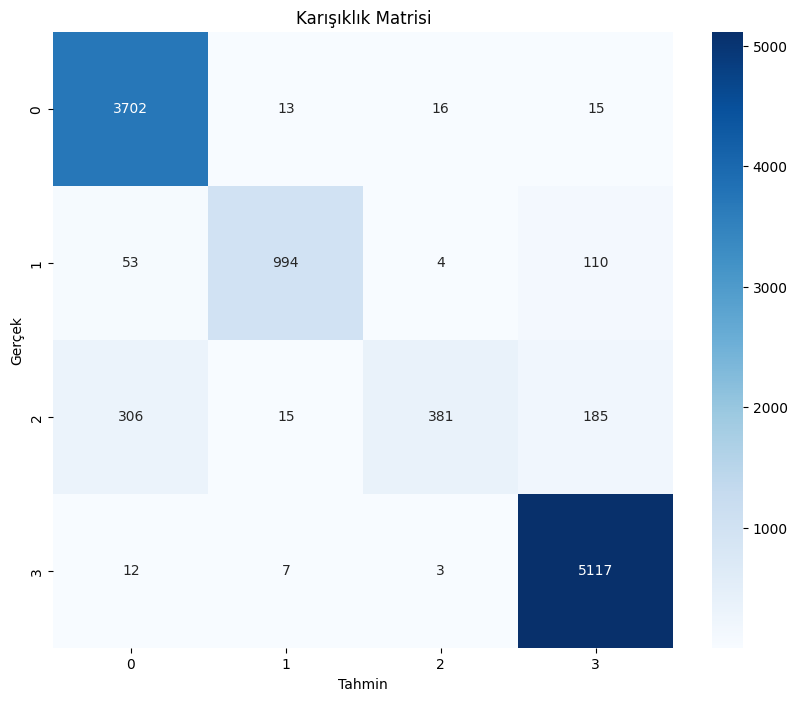

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, final_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()


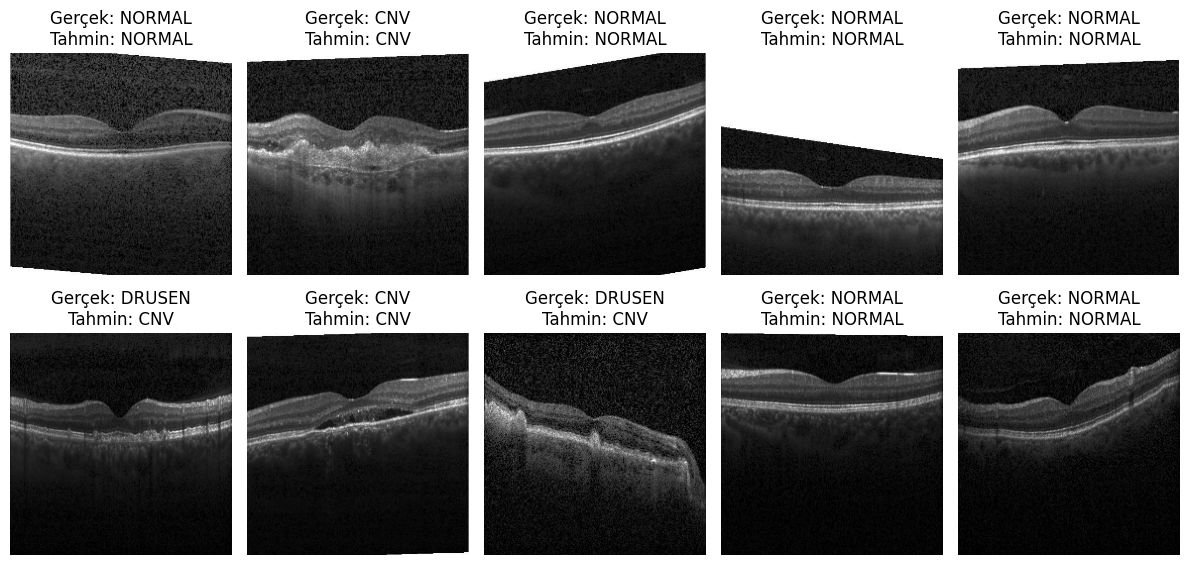

In [ ]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']  # kendi sınıf isimlerini yaz

import random

plt.figure(figsize=(12, 6))
for i in range(10):
    idx = random.randint(0, len(test_images) - 1)
    img = test_images[idx]
    true_label = test_labels[idx]
    pred_label = final_predictions[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.title(f"Gerçek: {class_names[true_label]}\nTahmin: {class_names[pred_label]}")
plt.tight_layout()
plt.show()


In [ ]:
# Eğer test_labels hala one-hot encoded ise önce düzelt:
if len(test_labels.shape) > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Her modelin doğruluğu
acc1 = accuracy_score(test_labels, np.argmax(pred_tf1, axis=1))
acc2 = accuracy_score(test_labels, np.argmax(pred_tf2, axis=1))
acc3 = accuracy_score(test_labels, np.argmax(pred_tf3, axis=1))

print(f"Densenet Doğruluk: {acc1:.4f}")
print(f"efficinet Doğruluk: {acc2:.4f}")
print(f"resnet Doğruluk: {acc3:.4f}")


Densenet Doğruluk: 0.8573
efficinet Doğruluk: 0.9164
resnet Doğruluk: 0.9361


In [ ]:
ensemble_acc = accuracy_score(test_labels, final_predictions)
print(f"Soft Ensemble Doğruluk: {ensemble_acc:.4f}")


Soft Ensemble Doğruluk: 0.9324


In [ ]:
import numpy as np

# Ensemble ortalaması
ensemble_prob = np.mean([pred_tf1, pred_tf2, pred_tf3], axis=0)

# Her örnek için modellerin tahmin olasılıklarıyla ensemble arasındaki fark
diff1 = np.linalg.norm(ensemble_prob - pred_tf1, axis=1)
diff2 = np.linalg.norm(ensemble_prob - pred_tf2, axis=1)
diff3 = np.linalg.norm(ensemble_prob - pred_tf3, axis=1)

closest_model = np.argmin([diff1, diff2, diff3], axis=0)  # 0: model1, 1: model2, 2: model3

# Kaç örnekte hangi model ensemble’a daha yakındı?
import collections
print("Ensemble'a en yakın model dağılımı:", collections.Counter(closest_model))


Ensemble'a en yakın model dağılımı: Counter({np.int64(1): 6033, np.int64(0): 3295, np.int64(2): 1605})


Model 1 - Accuracy: 0.8573, F1 Score: 0.8441
Model 2 - Accuracy: 0.9164, F1 Score: 0.9112
Model 3 - Accuracy: 0.9361, F1 Score: 0.9285
Ensemble - Accuracy: 0.9324, F1 Score: 0.9240


<ipython-input-52-2e74decaf824>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


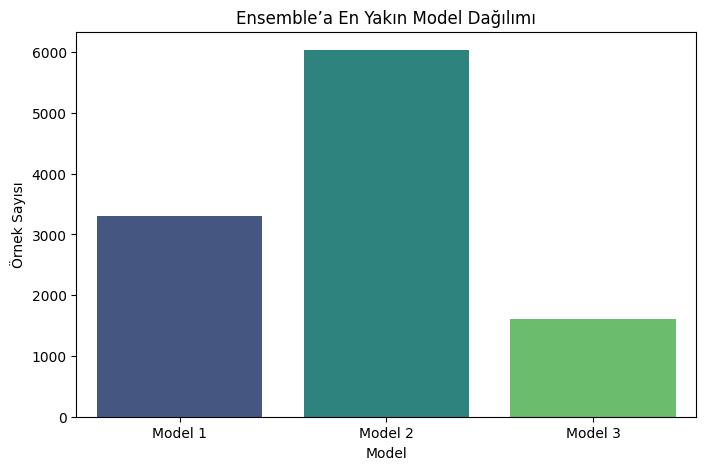

      Model  Accuracy  F1 Score
0   Model 1  0.857313  0.844121
1   Model 2  0.916400  0.911166
2   Model 3  0.936065  0.928511
3  Ensemble  0.932406  0.924006


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import collections

# === Eğer test_labels one-hot ise düzelt ===
if len(test_labels.shape) > 1:
    test_labels = np.argmax(test_labels, axis=1)

# === Her modelin tahminleri ===
preds = [pred_tf1, pred_tf2, pred_tf3]

# === Her modelin doğruluk skorları ===
accuracies = []
f1s = []
for i, pred in enumerate(preds):
    pred_labels = np.argmax(pred, axis=1)
    acc = accuracy_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels, average='weighted')
    accuracies.append(acc)
    f1s.append(f1)
    print(f"Model {i+1} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# === Ensemble doğruluğu ===
ensemble_probs = np.mean(preds, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_acc = accuracy_score(test_labels, ensemble_preds)
ensemble_f1 = f1_score(test_labels, ensemble_preds, average='weighted')
print(f"Ensemble - Accuracy: {ensemble_acc:.4f}, F1 Score: {ensemble_f1:.4f}")

# === Ensemble'a en yakın model analizi ===
diffs = [np.linalg.norm(ensemble_probs - pred, axis=1) for pred in preds]
closest_model = np.argmin(diffs, axis=0)
closest_count = collections.Counter(closest_model)

# === Bar Chart ===
labels = [f"Model {i+1}" for i in range(len(preds))]
counts = [closest_count.get(i, 0) for i in range(len(preds))]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.title("Ensemble’a En Yakın Model Dağılımı")
plt.ylabel("Örnek Sayısı")
plt.xlabel("Model")
plt.show()

# === Tablo: Karşılaştırmalı metrikler ===
df = pd.DataFrame({
    'Model': [f"Model {i+1}" for i in range(len(preds))] + ['Ensemble'],
    'Accuracy': accuracies + [ensemble_acc],
    'F1 Score': f1s + [ensemble_f1]
})
print(df)


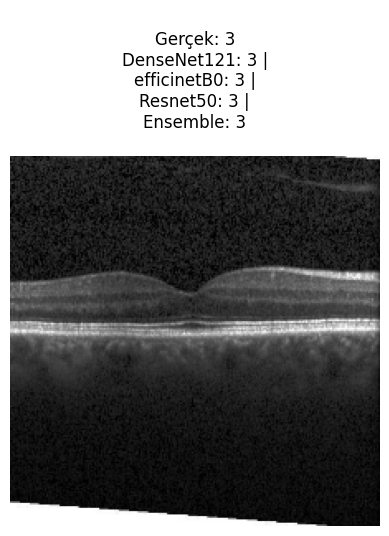

In [ ]:
import matplotlib.pyplot as plt
import random

i = random.randint(0, len(test_labels)-1)

plt.imshow(test_images[i].astype('uint8'))
plt.axis("off")
plt.title(f"""
Gerçek: {test_labels[i]}
DenseNet121: {np.argmax(pred_tf1[i])} |
efficinetB0: {np.argmax(pred_tf2[i])} |
Resnet50: {np.argmax(pred_tf3[i])} |
Ensemble: {final_predictions[i]}
""")
plt.show()


            Model  Accuracy  F1 Score
0     DenseNet121  0.857313  0.844121
1  EfficientNetB0  0.916400  0.911166
2        ResNet50  0.936065  0.928511
3   Soft Ensemble  0.932406  0.924006


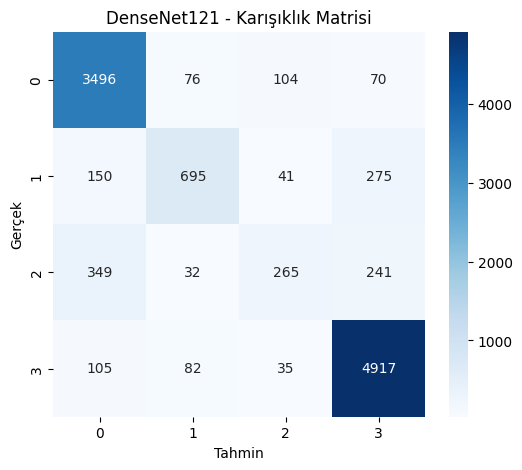

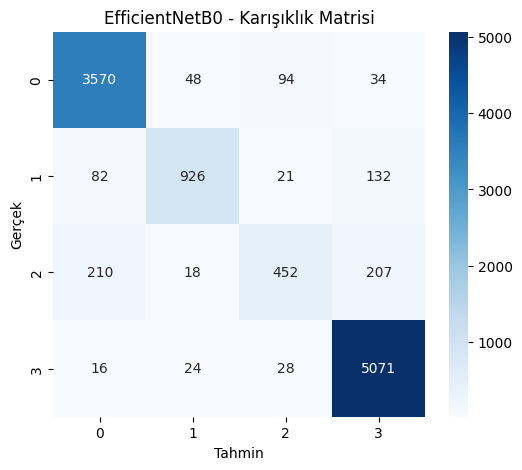

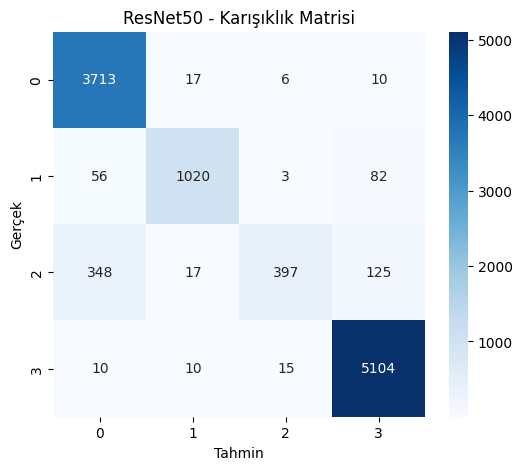

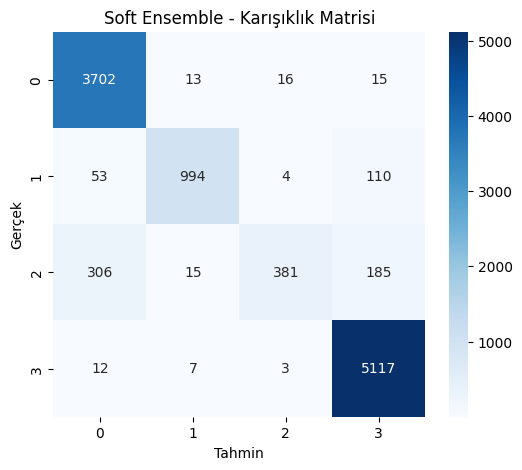

Soft Ensemble - Yanlış Sınıflandırılan Görseller:


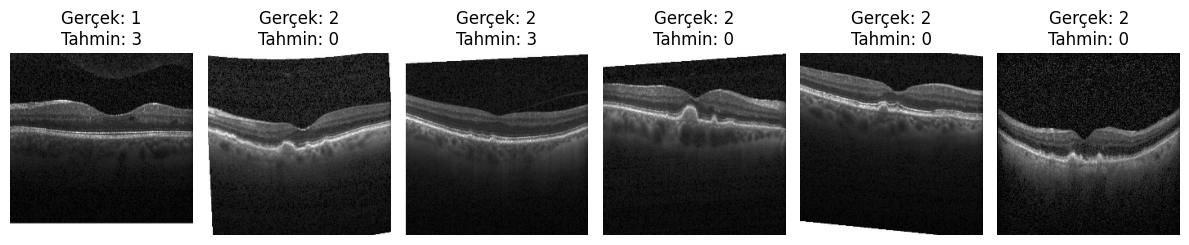

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd
import random

# One-hot düzeltmesi
if len(test_labels.shape) > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Tahminler ve isimler
preds = [pred_tf1, pred_tf2, pred_tf3]
model_names = ["DenseNet121", "EfficientNetB0", "ResNet50"]  # örnek isimler
ensemble_probs = np.mean(preds, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# === METRİK TABLOSU ===
accuracy_list = []
f1_list = []

for i, pred in enumerate(preds):
    pred_labels = np.argmax(pred, axis=1)
    acc = accuracy_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels, average='weighted')
    accuracy_list.append(acc)
    f1_list.append(f1)

# Ensemble
acc_ens = accuracy_score(test_labels, ensemble_preds)
f1_ens = f1_score(test_labels, ensemble_preds, average='weighted')
accuracy_list.append(acc_ens)
f1_list.append(f1_ens)
model_names.append("Soft Ensemble")

# === METRİK TABLOSU ÇIKTISI ===
df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_list,
    'F1 Score': f1_list
})
print(df)

# === CONFUSION MATRICES ===
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.show()

# Her model için karışıklık matrisi
for i, pred in enumerate(preds):
    pred_labels = np.argmax(pred, axis=1)
    plot_conf_matrix(test_labels, pred_labels, f"{model_names[i]} - Karışıklık Matrisi")

# Ensemble için
plot_conf_matrix(test_labels, ensemble_preds, "Soft Ensemble - Karışıklık Matrisi")

# === YANLIŞ SINIFLANDIRILAN ÖRNEKLERDEN ÖRNEKLER ===
def plot_misclassified_images(y_true, y_pred, images, n=6):
    wrong = np.where(y_true != y_pred)[0]
    samples = np.random.choice(wrong, size=min(n, len(wrong)), replace=False)

    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(samples):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx].astype("uint8"))
        plt.axis("off")
        plt.title(f"Gerçek: {y_true[idx]}\nTahmin: {y_pred[idx]}")
    plt.tight_layout()
    plt.show()

print("Soft Ensemble - Yanlış Sınıflandırılan Görseller:")
plot_misclassified_images(test_labels, ensemble_preds, test_images, n=6)


In [ ]:
df.to_csv("ensemble_model_sonuclari.csv", index=False)
